**RANDOM FOREST REGRESSOR**

In this approach, I try to adopt some codes from xavier, vamsi and arnab to clean and restructure the data. However, the chart for test vs predicted data shows the algorithm needs more improvement. 

In [0]:
#Import all needed libraries for this project
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [0]:
df = pd.read_csv('OUTPUT_WBI_exposer_cyclones_v10.csv')

In [86]:
df.head().T

,0,1,2,3,4
Unnamed: 0,0,1,2,3,4
SID,1949163N07145,1950241N23140,1951224N12316,1951337N09150,1952180N05144
NAME,DELLA,JANE,CHARLIE,AMY,EMMA
ISO,JPN,JPN,JAM,PHL,PHL
YEAR,1949,1950,1951,1951,1952
BASIN,WP,WP,NAm,WP,WP
SUB BASIN,WP,WP,CS,WP,WP
NATURE,TS,ET,TS,TS,TS
ISO_TIME,"['1949-06-21 03:00:00', '1949-06-22 03:00:00',...","['1950-09-02 18:00:00', '1950-09-03 12:00:00',...","['1951-08-17 21:00:00', '1951-08-18 12:00:00']","['1951-12-08 18:00:00', '1951-12-08 21:00:00',...","['1952-07-01 18:00:00', '1952-07-01 21:00:00',..."
COORDS,"[[35.67, 130.99], [38.35, 135.07], [38.82, 136...","[[31.71, 134.12], [38.48, 137.98], [46.7, 152.8]]","[[17.34, -75.41], [18.3, -79.4]]","[[11.52, 127.35], [11.34, 127.09], [11.17, 126...","[[9.57, 127.79], [9.63, 127.19], [12.38, 119.4..."


In [0]:
#adopted from vamsi codes
df['MONTH'] = df['ISO_TIME'].apply(lambda x: [int(i[7:9]) for i in eval(x)][0])
df.drop('ISO_TIME', axis=1, inplace=True)

In [0]:
#Adopted from Arnab's code
unique_list = df['Income_level_Final'].unique()
incomelevel_to_int = dict(zip(unique_list, [1,2,4,3])) # so we assign['Low' =1, 'Low_Middle' =2, 'High'=4, 'High_Middle'=3]
df['Income_level_Final'] = df['Income_level_Final'].apply(lambda inc_level: incomelevel_to_int[inc_level])

In [0]:
#adopted from vamsi codes
#BASIN and SUBBASIN: 'MM' value means missing, and USA_SSHS column with value -5 = Unknown [XX]:
df["SUB BASIN"] = df["SUB BASIN"].replace('MM', np.nan) 
df["BASIN"] = df["BASIN"].replace('MM', np.nan) 
df["USA_SSHS"]= df["USA_SSHS"].replace(-5, np.nan)

In [0]:
#adopted from xavier tores's codes
#As damage in '000 USD is time-money sensitive, we can use the CPI for that data point to calculate "Total Damage Adjusted" by dividing Total Damage by the CPI. We then drop columns for Damage and CPI. CPI meaning = https://en.wikipedia.org/wiki/Consumer_price_index
df["TOTAL_DAMAGE_(000$)_Adjusted"]= df["TOTAL_DAMAGE_(000$)"] / df["CPI"]
df["TOTAL_DAMAGE_(000$)_Adjusted"]= df["TOTAL_DAMAGE_(000$)_Adjusted"].replace(0, np.nan)

In [74]:
#adopted from xavier tores's codes
df = df.drop(["TOTAL_DAMAGE_(000$)",'CPI'], axis=1)
df["TOTAL_DAMAGE_(000$)_Adjusted"].isna().sum()

319

In [0]:
#adopted from xavier tores's codes
df['CALC_assets_emdat'] = df['34KN_ASSETS'] + df['64KN_ASSETS'] + df['96KN_ASSETS']
df = df.drop(['64KN_ASSETS', '96KN_ASSETS','96KN_ASSETS'], axis=1)

In [89]:
df.shape
df.columns

Index(['Unnamed: 0', 'SID', 'NAME', 'ISO', 'YEAR', 'BASIN', 'SUB BASIN',
       'NATURE', 'COORDS', 'TOTAL_HRS', 'DAY_HRS', 'NIGHT_HRS', 'USA_SSHS',
       'WIND_CALC_MEAN', 'PRES_CALC_MEAN', 'STORM_SPD_MEAN', 'STORM_DR_MEAN',
       'V_LAND_KN', '34KN_POP', '34KN_ASSETS', '64KN_POP', '96KN_POP', 'CPI',
       'TOTAL_DAMAGE_(000$)', 'TOTAL_DEATHS',
       'Air transport, freight (million ton-km)',
       'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)', 'GDP growth (annual %)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Mobile cellular subscriptions (per 100 people)',
       'Population density (people per sq. km of land area)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Rural population (% of total population)', 'Income_level_Final',
       'TOTAL_AFFECTED', 'in_wbi', 'pop_max_34', 'pop_max_50', 'p

In [90]:
df.shape

(1005, 48)

In [0]:
#adopted from xavier tores's codes
# One Hot encoding for the rest of the categorical variables
obj_feats = df.dtypes[df.dtypes == 'object'].index
obj_feats
feats_to_dummy = obj_feats #selecting feats to make one-hot encoding

for feature in feats_to_dummy:
    dummy = pd.get_dummies(df[feature], prefix=feature)
    df = pd.concat([df,dummy], axis=1)


In [0]:

# Dropping dummed features
df = df.drop(feats_to_dummy, axis=1)

In [0]:
#df.head(3)

In [98]:
df.info()
#sf = StandardScaler()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Columns: 2444 entries, Unnamed: 0 to Income_level_Final_Low_Middle
dtypes: bool(1), float64(31), int64(8), uint8(2404)
memory usage: 2.6 MB


In [0]:
#df['YEAR'] = 2020 - df['YEAR']

In [100]:
df.shape

(1005, 2444)

In [101]:
df=df.dropna()
df.shape

(439, 2444)

In [0]:
mm = MinMaxScaler()
sf = StandardScaler()

In [0]:
Y = df['TOTAL_AFFECTED']
X = df.drop('TOTAL_AFFECTED',axis=1)

In [0]:
#Sampling as a target variable for better sampling
samples = 20*np.arange(16)
Y = np.digitize(Y, samples) 

In [0]:
# Split train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state=25, shuffle=True, stratify=Y)


In [0]:
columns = list(X_train.columns)
X_TRain = pd.DataFrame(mm.fit_transform(X_train),columns = columns)
#X_TRain = mm.fit_transform(X_train)
X_TEst = pd.DataFrame(mm.transform(X_test),columns=columns)
#X_TEst = mm.transform(X_test)

In [0]:
#NeXt Step is to Scale features by standardizing
X_train = sf.fit_transform(X_TRain)
X_test = sf.transform(X_test)

#Before Scaling, let's perform a pca through normalization
pca = PCA(n_components=1)
X_train  = pca.fit_transform(X_train)
X_test  = pca.fit_transform(X_test)

Root Mean Squared Error:, 0.29
Test Variance Score: -0.0909
R^2 Prediction Score: 0.8212


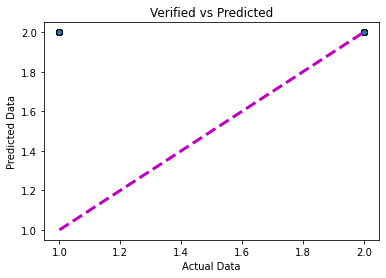

In [110]:
#Training the algorithm with the sample dataset
estModel = RandomForestRegressor(n_estimators = 700, random_state = 5)
estModel.fit(X_train, Y_train)
#Model Score
mScore = estModel.score(X_train,Y_train)

#Prediction
Predict_Y = estModel.predict(X_test)

#Evaluating algorithm performance
#MSE Result
rmse = mean_squared_error(Y_test,Predict_Y)
print('Root Mean Squared Error:, %.2f' % np.sqrt(rmse))
#Variance score: 1 is perfect prediction score
print('Test Variance Score: %.4f' % r2_score(Y_test, Predict_Y))
#Variance score: 1 is perfect prediction score
print('R^2 Prediction Score: %.4f'% mScore)

#Root Mean Squared Error
#mse = np.sqrt(np.mean((Y_test - Predict_Y)**2))
#time.sleep(1)
#rint('Root Mean Square Error: %.4f'%rmse)
#Run the model against the test data presented through a plot
fig, pX = plt.subplots()

pX.scatter(Y_test, Predict_Y, edgecolors=(0, 0, 0))
pX.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'm--', lw=3)
pX.set_xlabel('Actual Data')
pX.set_ylabel('Predicted Data')
pX.set_title("Verified vs Predicted")
plt.show()
